# Data Integration

In [ ]:
import os, re, sys
import fcsparser
import pandas as pd

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts.__init__ import non_marker


In [ ]:
# Import raw data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/WENR Permutation"
os.makedirs(f"{base_dir}/output", exist_ok=True)
input_dir = f"{base_dir}/preprocessed_data"
output_dir = f"{base_dir}/output"

filelist = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
filelist


In [ ]:
# ---
# Integration
# ---

# Naming convention:
# batch_experiment_barcode_genotype(-Fib)_barcode_medium_cell-type_replicate
# e.g. "B1_WENR_001_WT_Ctrl_Org_1.txt"

integrated = pd.DataFrame()
for f in filelist:
    df_new = pd.read_csv(f"{input_dir}/{f}", sep="\t")
    df_new = df_new.rename(
        columns=lambda x: re.sub("_v[0-9]+$", "", x)
    )  # Revome the version number etc.

    batch = f.split("_")[0]
    culture = f.split("_")[3]
    media = f.split("_")[4]
    replicate = f.split("_")[-1].split(".")[0]
    cell_type = f.split("_")[-2]
    if culture != "Fib":
        genotype = culture.split("-")[0] if len(culture.split("-")) > 1 else culture
    else:
        genotype = "NA"
    # co_culture = 1 if len(culture.split("-")) > 1 else 0
    format = "co-culture" if len(culture.split("-")) > 1 else "monoculture"

    df_new["batch"] = batch
    df_new["replicate"] = replicate
    df_new["condition"] = culture + "_" + media + "_" + cell_type + "_" + replicate
    df_new["culture"] = culture + "_" + media
    df_new["format"] = format
    df_new["cell-type"] = cell_type

    df_new["media"] = media
    # break down media component
    df_new["W"] = 1 if "W" in media else 0
    df_new["E"] = 1 if "E" in media else 0
    df_new["N"] = 1 if "N" in media else 0
    df_new["R"] = 1 if "R" in media else 0

    df_new["genotype"] = genotype
    # break down genotype
    df_new["A"] = 1 if "A" in genotype else 0
    df_new["K"] = 1 if "K" in genotype else 0
    df_new["P"] = 1 if "P" in genotype else 0

    integrated = pd.concat([integrated, df_new])
integrated.head()
integrated.shape # (3724496, 82)

integrated.columns.values
integrated.to_csv(f"{output_dir}/integrated_dataframe_all-cells.csv", index=False)

## Prepare datasets for Sacffold

Concatenated controls for all genotypes.

In [ ]:
# Generate full_panel list from integrated DataFrame
df_columns = integrated.columns.values.tolist()
column_filtered = list(
    filter(lambda x: x not in non_marker, df_columns)
)  # Exclude non-markers

full_panel = [i for i in column_filtered if i[0].isdigit()]
metadata_columns = list(filter(lambda x: x not in full_panel, column_filtered))

In [ ]:
integrated_monoculture_controls = integrated[
    (integrated["format"] == "monoculture") & (integrated["media"] == "Ctrl")
]

cultures = integrated_monoculture_controls["culture"].unique()
cultures

for culture in cultures:
    integrated_monoculture_control_subset = integrated_monoculture_controls[
        integrated_monoculture_controls["culture"] == culture
    ]
    integrated_monoculture_control_subset = master_df_subset(
        integrated_monoculture_control_subset, full_panel
    )
    integrated_monoculture_control_subset.to_csv(
        f"{output_dir}/concat_{culture}.csv", index=False
    )

# EMD Calculation

In [5]:
import os
import pandas as pd
import scprep
from scipy.stats import zscore

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts.__init__ import non_marker


<IPython.core.display.Javascript object>

In [6]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/WENR Permutation"
input_dir = f"{base_dir}/output"
os.makedirs(f"{base_dir}/output/emd", exist_ok=True)
output_dir = f"{base_dir}/output/emd"


<IPython.core.display.Javascript object>

In [7]:
# Generate full_panel and metadata_columns on the fly
df = pd.read_csv(f"{input_dir}/integrated_dataframe_all-cells.csv")
df_columns = df.columns.values.tolist()
column_filtered = list(
    filter(lambda x: x not in non_marker, df_columns)
)  # Exclude non-markers

full_panel = [i for i in column_filtered if i[0].isdigit()]
metadata_columns = list(filter(lambda x: x not in full_panel, column_filtered))


<IPython.core.display.Javascript object>

In [8]:
# EMD calculation

df_arc = arcsinh_transf(df, full_panel, 5) # Arcsinh transformation
emd_ref = df_arc.loc[df_arc["culture"] == "WT_Ctrl"]  #! Set reference for EMD calculation
emd_ref.shape # (31007, 82)

emd_df = pd.DataFrame()
emd_df_master = pd.DataFrame()
emd_infodict = {}

# Get all experimental conditions for which EMD is going to be calculated
conditions = df_arc["condition"].unique().tolist()
len(conditions) # 360

# Compute EMD and compile the result in a master dataframe
for condition in conditions:
    compare_from = df_arc.loc[df_arc["condition"] == condition]
    df = calculate_emd(
        full_panel,  # all antibody measurements
        compare_from,
        emd_ref,
        metadata_columns,
        emd_df,
        emd_infodict,
    )
    emd_df_master = pd.concat([emd_df_master, df])
emd_df_master.head()

# Long to wide transformation
emd_df_master_wide = emd_df_master.pivot_table(
    index=metadata_columns,
    columns="marker",
    values="EMD_arc",
).reset_index()

emd_df_master_wide.head()
emd_df_master_wide.to_csv(
    f"{output_dir}/emd_df_master_all-cells_no-norm.csv",
    index=False,
)

# Z-score normalisation
# retrieve data and metadata
emd_df_master_wide_metadata = emd_df_master_wide[metadata_columns].reset_index()
emd_df_master_wide_data = master_df_subset(emd_df_master_wide, full_panel)

# z-score
emd_df_master_wide_data_scaled = emd_df_master_wide_data.apply(zscore).reset_index()

emd_df_master_wide_data_scaled = pd.merge(
    emd_df_master_wide_data_scaled, emd_df_master_wide_metadata, on="index"
)
emd_df_master_wide_data_scaled.drop(columns=["index"], inplace=True)

emd_df_master_wide_data_scaled.to_csv(
    f"{output_dir}/emd_df_master_all-cells_z-score.csv", index=False
)

(31007, 82)

<IPython.core.display.Javascript object>

# Figure 3B-E - All-condition Overview

In [1]:
import os, sys
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../..') # Add the script folder to the path
from scripts.aux_functions import *
from scripts import colours

from IPython.core.interactiveshell import InteractiveShell
%load_ext nb_black

<IPython.core.display.Javascript object>

In [10]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/WENR Permutation"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
norm = "z-score"

emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_all-cells_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide.columns

# Define markers used for PHATE
dr_panel = [
    # cell-state
    '89Y_pHH3_S28',
    '127I_IdU',
    '142Nd_cCaspase_3_D175',
    '150Nd_pRB_S807_S811',
    '172Yb_cCaspase_8_D387',
    '173Yb_Cyclin_B1_2',
    # cell-type
    '143Nd_C-MYC_1',
    '111Cd_CD44',
    '162Dy_LRIG1_1',
    '169Tm_EPHB2',
    '171Yb_SOX9_5',
    '174Yb_Clusterin_1',
    '175Lu_Survivin_2',
    '176Yb_FABP2',
    '113In_CEACAM1_CD66a',
    '115In_Pan-CK',
    '116Cd_GFP',
    # PTMs
    '141Pr_pPDPK1_S241',
    '145Nd_pNDRG1_T346',
    '146Nd_pMKK4_SEK1_S257',
    '147Sm_pBTK_Y511_1',
    '148Nd_pSRC_Y418',
    '149Sm_p4EBP1_T37_T46',
    '151Eu_pPKCa_T497',
    '152Sm_pAKT_T308',
    '153Eu_pCREB_S133',
    '154Sm_pSMAD1_5_9',
    '155Gd_pAKT_S473_3',
    '156Gd_pNF-kB_p65_S529',
    '157Gd_pMKK3_MKK6_S189_207',
    '158Gd_pP38_MAPK_T180_Y182',
    '159Tb_pMAPKAPK2_T334',
    '160Gd_pAMPKa_T172',
    '161Dy_pBAD_S112',
    '163Dy_pP90RSK_T359_Hu',
    '164Dy_pP120-Catenin_T310',
    '165Ho_Beta-catenin_Active_1',
    '166Er_pGSK-3b_S9',
    '167Er_pERK_1_2_T202_Y204',
    '168Er_pSMAD2_3',
    '170Er_pMEK1_2_S221',
    '209Bi_DiMeHH3_K4'
]

dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)


<IPython.core.display.Javascript object>

In [11]:
# PHATE

phate_operator = phate.PHATE(knn=15, t=10, mds_solver="smacof", random_state=42)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index()
Y_phate_df = pd.merge(emd_df_master_wide, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_phate_df.head()

Calculating PHATE...
  Running PHATE on 360 observations and 42 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.97 seconds.
Calculated PHATE in 1.04 seconds.


,106Cd_RFP,110Cd_mCherry,111Cd_CD44,113In_CEACAM1_CD66a,115In_Pan-CK,116Cd_GFP,127I_IdU,140Ce_EQ_Beads,141Pr_pPDPK1_S241,142Nd_cCaspase_3_D175,...,W,E,N,R,genotype,A,K,P,0,1
0,-0.615245,-0.664661,0.012872,-0.706297,-1.576418,0.851806,1.276232,-0.906203,-0.997283,-0.969035,...,0,0,0,0,AK,1,1,0,-0.052095,-0.028481
1,-0.625036,-0.674579,0.557923,-0.269641,-1.271131,0.792009,0.897541,-1.398140,-1.099556,-1.372896,...,0,1,1,1,AK,1,1,0,-0.051430,-0.029771
2,-0.491127,0.511107,0.200791,-0.004804,-1.105947,0.927765,0.902756,-1.094674,-0.885632,-1.072046,...,0,1,0,0,AK,1,1,0,-0.035426,-0.038265
3,-0.592674,-0.627179,0.091836,-0.757078,-1.481553,0.861432,1.383342,-1.040436,-1.082116,-1.274801,...,0,0,1,0,AK,1,1,0,-0.049580,-0.027732
4,-0.630566,-0.660873,0.307169,-0.750876,-1.688537,0.826294,1.211871,-0.914651,-1.169283,-1.026160,...,0,0,0,1,AK,1,1,0,-0.052258,-0.028558


<IPython.core.display.Javascript object>

## Figure 3B - Genotype

(-0.06104159344981391,
 0.08209025359808851,
 -0.047049738097548116,
 0.05773920143051603)

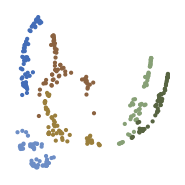

<IPython.core.display.Javascript object>

In [14]:
# ---
# Figure 3B - Genotype
# ---

fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "genotype"],
    cmap=colours,
    ticks=False,
    s=4,
    label=None,
    legend=False,
    # title="culture",
    figsize=(2.2, 2.2),
)
fig.axis("off")

## Figure 3C - Microenvironment

(-0.06104159344981391,
 0.08209025359808851,
 -0.047049738097548116,
 0.05773920143051603)

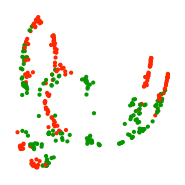

<IPython.core.display.Javascript object>

In [15]:
# ---
# Figure 3C - Microenvironment
# ---

fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "format"],
    cmap=colours,
    ticks=False,
    s=4,
    label=None,
    legend=False,
    # title="culture",
    figsize=(2.2, 2.2),
)
fig.axis("off")

## Figure 3D - Ligand

(-0.06104159344981391,
 0.08209025359808851,
 -0.047049738097548116,
 0.05773920143051603)

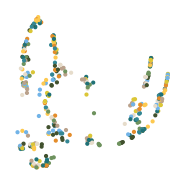

<IPython.core.display.Javascript object>

In [16]:
# ---
# Figure 3D - Ligand
# ---

fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "media"],
    cmap=colours,
    ticks=False,
    s=4,
    label=None,
    legend=False,
    # title="culture",
    figsize=(2.2, 2.2),
)
fig.axis("off")

## CLU, SURVIVIN, Pan-CK, LRIG1

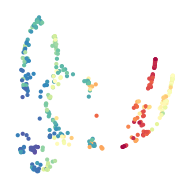

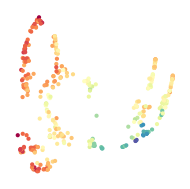

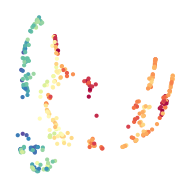

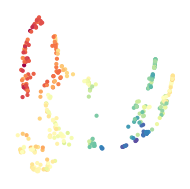

<IPython.core.display.Javascript object>

In [18]:
for marker in ["174Yb_Clusterin_1", "175Lu_Survivin_2", "115In_Pan-CK", "162Dy_LRIG1_1"]:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=4,
        xlabel="",
        ylabel="",
        legend=False,
        title="",
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")


# Figure 4A, S4A-B - Monocultures

In [19]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/WENR Permutation"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
norm = "z-score"

emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_all-cells_{norm}.csv")

# Subset on monocultures
emd_df_monocultures = emd_df_master_wide[emd_df_master_wide["format"]=="monoculture"]


(180, 64)

<IPython.core.display.Javascript object>

In [20]:
emd_df_master_wide=emd_df_monocultures.copy()

dr_panel = [
    # cell-type
    '143Nd_C-MYC_1',
    '111Cd_CD44',
    '162Dy_LRIG1_1',
    '169Tm_EPHB2',
    '171Yb_SOX9_5',
    '174Yb_Clusterin_1',
    '175Lu_Survivin_2',
    '176Yb_FABP2',
]

dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)

<IPython.core.display.Javascript object>

In [23]:
# PHATE

phate_operator = phate.PHATE(
    knn=15, t="auto", random_state=42, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)

<IPython.core.display.Javascript object>

## Figure 4A - Signalling (Grouped)

(-0.10289479954440099,
 0.11394919097129576,
 -0.02668059856505719,
 0.025865744968572087)

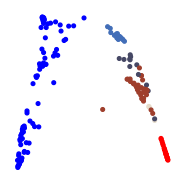

<IPython.core.display.Javascript object>

In [24]:
# PHATE preview
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "culture"],
    cmap=colours,
    ticks=False,
    s=7,
    label=None,
    legend=False,
    figsize=(2.2, 2.2),
)
fig.axis('off')

## Figure S4A - Genotype

(-0.10289479954440099,
 0.11394919097129576,
 -0.02668059856505719,
 0.025865744968572087)

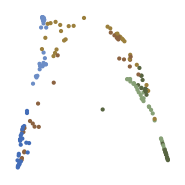

<IPython.core.display.Javascript object>

In [25]:
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "genotype"],
    cmap=colours,
    ticks=False,
    s=4,
    label=None,
    legend=False,
    figsize=(2.2, 2.2),
)
fig.axis('off')

## Figure S4B - Ligand

(-0.10289479954440099,
 0.11394919097129576,
 -0.02668059856505719,
 0.025865744968572087)

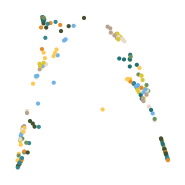

<IPython.core.display.Javascript object>

In [26]:
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "media"],
    cmap=colours,
    ticks=False,
    s=4,
    label=None,
    legend=False,
    figsize=(2.2, 2.2),
)
fig.axis('off')

## Figure 4B - Selected Markers

revCSC: CLU, pGSK-3β [S9], 
Equilibrium: Pan-CK, FABP2, pNDRG1 [T346], pMKK3/6 [S189/207]
proCSC: LRIG1, SURVIVIN, EPHB2, IdU, pMK2 [T334], pAKT [T308]

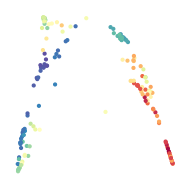

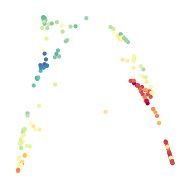

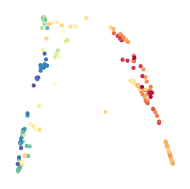

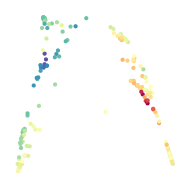

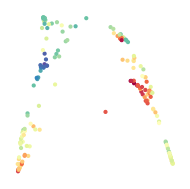

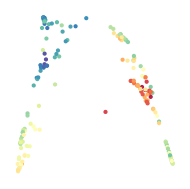

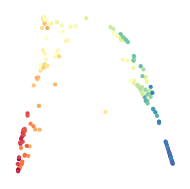

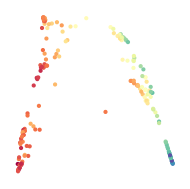

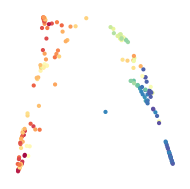

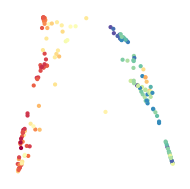

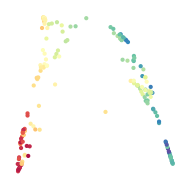

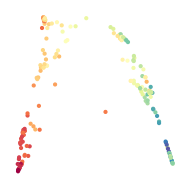

<IPython.core.display.Javascript object>

In [28]:
marker_list = [
    "174Yb_Clusterin_1",
    "166Er_pGSK-3b_S9",
    "115In_Pan-CK",
    "176Yb_FABP2",
    "145Nd_pNDRG1_T346",
    "157Gd_pMKK3_MKK6_S189_207",
    "162Dy_LRIG1_1",
    "175Lu_Survivin_2",
    "169Tm_EPHB2",
    "127I_IdU",
    "159Tb_pMAPKAPK2_T334",
    "152Sm_pAKT_T308"
    ]

for marker in marker_list:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=4,
        xlabel="",
        ylabel="",
        legend=False,
        title="",
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")

## Figure S3 - WT Monoculture vs Co-culture

In [44]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/WENR Permutation"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
norm = "z-score"

emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_all-cells_{norm}.csv")

# Subset on WT
emd_df_wt = emd_df_master_wide[emd_df_master_wide["genotype"]=="WT"]
emd_df_master_wide=emd_df_wt.copy()

<IPython.core.display.Javascript object>

In [45]:
# Define markers used for PHATE
dr_panel = [
    # cell-state
    '89Y_pHH3_S28',
    '127I_IdU',
    '142Nd_cCaspase_3_D175',
    '150Nd_pRB_S807_S811',
    '172Yb_cCaspase_8_D387',
    '173Yb_Cyclin_B1_2',
    # cell-type
    '143Nd_C-MYC_1',
    '111Cd_CD44',
    '162Dy_LRIG1_1',
    '169Tm_EPHB2',
    '171Yb_SOX9_5',
    '174Yb_Clusterin_1',
    '175Lu_Survivin_2',
    '176Yb_FABP2',
    '113In_CEACAM1_CD66a',
    '115In_Pan-CK',
    # '116Cd_GFP', # GFP excluded
    # PTMs
    '141Pr_pPDPK1_S241',
    '145Nd_pNDRG1_T346',
    '146Nd_pMKK4_SEK1_S257',
    '147Sm_pBTK_Y511_1',
    '148Nd_pSRC_Y418',
    '149Sm_p4EBP1_T37_T46',
    '151Eu_pPKCa_T497',
    '152Sm_pAKT_T308',
    '153Eu_pCREB_S133',
    '154Sm_pSMAD1_5_9',
    '155Gd_pAKT_S473_3',
    '156Gd_pNF-kB_p65_S529',
    '157Gd_pMKK3_MKK6_S189_207',
    '158Gd_pP38_MAPK_T180_Y182',
    '159Tb_pMAPKAPK2_T334',
    '160Gd_pAMPKa_T172',
    '161Dy_pBAD_S112',
    '163Dy_pP90RSK_T359_Hu',
    '164Dy_pP120-Catenin_T310',
    '165Ho_Beta-catenin_Active_1',
    '166Er_pGSK-3b_S9',
    '167Er_pERK_1_2_T202_Y204',
    '168Er_pSMAD2_3',
    '170Er_pMEK1_2_S221',
    '209Bi_DiMeHH3_K4'
]

dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)

<IPython.core.display.Javascript object>

In [46]:
phate_operator = phate.PHATE(
    knn=5, t=10, random_state=42, mds_solver="smacof", verbose=False
)
Y_phate = phate_operator.fit_transform(dr_matrix)

# Join PHATE coordinates with EMD dataframe
Y_phate_df = pd.DataFrame(Y_phate).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_phate_df = pd.merge(emd_df_master_wide, Y_phate_df, on="index")
Y_phate_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_phate_df.head()

,106Cd_RFP,110Cd_mCherry,111Cd_CD44,113In_CEACAM1_CD66a,115In_Pan-CK,116Cd_GFP,127I_IdU,140Ce_EQ_Beads,141Pr_pPDPK1_S241,142Nd_cCaspase_3_D175,...,W,E,N,R,genotype,A,K,P,0,1
0,-0.150404,-0.289963,0.446275,-0.066805,0.572189,-1.116779,-1.267079,1.264548,0.551637,0.915658,...,0,0,0,0,WT,0,0,0,0.049580,-0.056588
1,0.002220,-0.080041,1.386434,-0.267351,0.644216,-1.119105,-1.277352,0.952712,0.535808,1.575212,...,0,1,1,1,WT,0,0,0,0.142842,0.023638
2,0.209145,0.142751,1.767582,0.063891,0.771758,-1.080494,-1.186954,0.509612,1.387442,1.722054,...,0,1,0,0,WT,0,0,0,0.167792,0.059195
3,-0.086943,-0.219809,0.464098,-0.180954,0.729358,-1.081009,-0.933995,1.288391,0.743318,1.248293,...,0,0,1,0,WT,0,0,0,0.057698,-0.052332
4,-0.103764,-0.223331,0.637752,-0.213370,0.532355,-1.112544,-0.933600,0.960081,0.485205,0.875344,...,0,0,0,1,WT,0,0,0,0.047688,-0.057185


<IPython.core.display.Javascript object>

## Figure S3D - Ligand vs Microenvironment (Grouped)

(-0.16182336463419264,
 0.18888617414025022,
 -0.07912898265728198,
 0.11527948718967063)

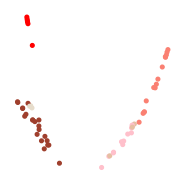

<IPython.core.display.Javascript object>

In [48]:
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "culture"],
    cmap=colours,
    ticks=False,
    s=7,
    label=None,
    legend=False,
    figsize=(2.2, 2.2),
)
fig.axis('off')

## Figure S3E - Ligand

(-0.16182336463419264,
 0.18888617414025022,
 -0.07912898265728198,
 0.11527948718967063)

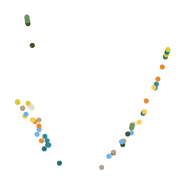

<IPython.core.display.Javascript object>

In [49]:
fig = scprep.plot.scatter2d(
    Y_phate_df.iloc[:, -2:],
    c=emd_df_master_wide.loc[:, "media"],
    cmap=colours,
    ticks=False,
    s=7,
    label=None,
    legend=False,
    figsize=(2.2, 2.2),
)
fig.axis('off')

## Figure S3F - Selected Markers

revCSC: CLU, SOX9
PTMs: pRB [S807/S811], pNDRG1 [T346], pMKK3/6 [S189/207], pP90RSK [T359], 
pGSK-3β [S9], pERK1/2 [T202/Y204], pMK2 [T334], pSMAD2/3 [S465/S467]

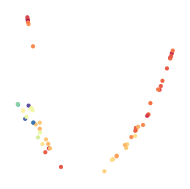

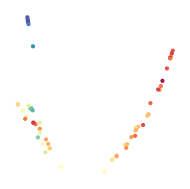

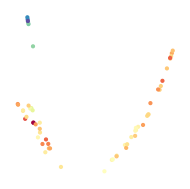

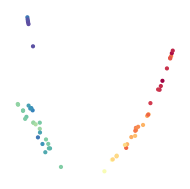

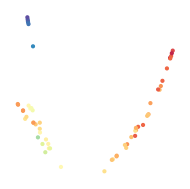

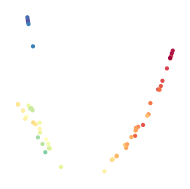

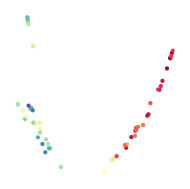

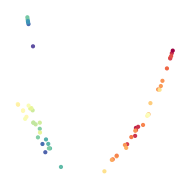

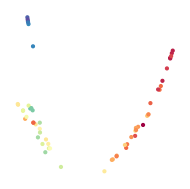

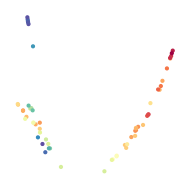

<IPython.core.display.Javascript object>

In [50]:
marker_list = [
    "174Yb_Clusterin_1",
    "171Yb_SOX9_5",
    "150Nd_pRB_S807_S811",
    "145Nd_pNDRG1_T346",
    "157Gd_pMKK3_MKK6_S189_207",
    "163Dy_pP90RSK_T359_Hu",
    "166Er_pGSK-3b_S9",
    "167Er_pERK_1_2_T202_Y204",
    "159Tb_pMAPKAPK2_T334",
    "168Er_pSMAD2_3",
    ]

for marker in marker_list:
    fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.2))
    fig = scprep.plot.scatter2d(
        Y_phate_df.iloc[:, -2:],
        c=Y_phate_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=4,
        xlabel="",
        ylabel="",
        legend=False,
        title="",
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")